### Emotion Analysis

In [ ]:
# Install necessary libraries for text processing, machine learning, and deep learning
!pip install emoji  # For handling emojis in text
!pip install contractions  # For expanding contractions in text
!pip install tensorflow  # TensorFlow, includes Keras
!pip install tqdm  # For showing progress bars in loops

# Install the latest version of tf-keras (usually covered by tensorflow install)
!pip install tf-keras  # Only necessary if you want a specific version

# Optional: Specific installs for Keras if needed separately
!pip install keras  # (TensorFlow already includes Keras)

# Uncomment if you haven't downloaded necessary NLTK corpora yet
# !pip install nltk  # In case NLTK isn't installed
# import nltk
# nltk.download('stopwords')  # For stopwords
# nltk.download('punkt')  # For tokenization


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
  Obtaining dependency information for numpy<2.0.0,>=1.23.5 from https://files.pythonhosted.org/packages/11/57/baae43d14fe163fa0e4c47f307b6b2511ab8d7d30177c491960504252053/numpy-1.26.4-cp311-cp311-macosx_10_9_x86_64.whl.metadata
  Using cached numpy-1.26.4-cp311-cp311-macosx_10_9_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-macosx_10_9_x86_64.whl (20.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


#### Import Libraries

In [3]:
# Data manipulation and cleaning
import pandas as pd
import numpy as np
import re
import emoji
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import pos_tag
from collections import Counter

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Machine Learning models and metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Deep Learning (Keras & TensorFlow)
import torch
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

# Word Embeddings (Gensim, FastText, Word2Vec)
import gensim
from gensim.models import Word2Vec, FastText

# Transformers
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, Trainer, TrainingArguments

# Progress bar
from tqdm import tqdm  # Progress bar for loops

# Downloading necessary NLTK resources
nltk.download('stopwords')

#### Load and Explore Data

In [5]:
def load_data(file_path):
    """Load the dataset from a file."""
    return pd.read_csv(file_path)

In [4]:
def explore_data(df, text_column='text', label_column='label'):
    """Perform an extensive exploration of the dataset to check data cleanliness."""

    print("\n--- Basic Information ---")
    print(f"Dataset Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(f"Missing Values:\n{df.isnull().sum()}")
    print(f"Duplicate Rows: {df.duplicated().sum()}")

    print("\n--- Class Distribution ---")
    if label_column in df.columns:
        print(df[label_column].value_counts())

        # Plot class distribution
        plt.figure(figsize=(8, 4))
        df[label_column].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
        plt.title("Class Distribution")
        plt.xlabel("Emotion Labels")
        plt.ylabel("Frequency")
        plt.show()
    else:
        print(f"No '{label_column}' column found!")

    print("\n--- Text Analysis ---")
    empty_texts = df[text_column].isnull().sum() + df[text_column].str.strip().eq('').sum()
    print(f"Empty or Blank Texts: {empty_texts}")

    # Checking text length distribution
    df['text_length'] = df[text_column].apply(lambda x: len(str(x).split()))
    print(f"Average Text Length: {df['text_length'].mean():.2f} words")
    print(f"Max Text Length: {df['text_length'].max()} words")
    print(f"Min Text Length: {df['text_length'].min()} words")

    # Checking for punctuation
    punctuations = df[text_column].apply(lambda x: len(re.findall(r'[^\w\s]', str(x))))
    print(f"Average Punctuation Count per Entry: {punctuations.mean():.2f}")

    # Check for emojis
    emojis_count = df[text_column].apply(lambda x: len(emoji.emoji_list(str(x))))
    print(f"Average Emoji Count per Entry: {emojis_count.mean():.2f}")

    # Checking for stop words
    stop_words = set(stopwords.words('english'))
    stop_word_counts = df[text_column].apply(lambda x: len([word for word in str(x).split() if word.lower() in stop_words]))
    print(f"Average Stop Words per Entry: {stop_word_counts.mean():.2f}")

    # Checking for numeric-only text (Fixed issue)
    numeric_texts = df[text_column].apply(lambda x: str(x).strip().isdigit()).sum()
    print(f"Entries with Only Numbers: {numeric_texts}")

    # Checking for excessive repeated characters
    repeated_char_counts = df[text_column].apply(lambda x: len(re.findall(r'(.)\1{2,}', str(x))))
    print(f"Average Excessive Repeated Characters per Entry: {repeated_char_counts.mean():.2f}")

    print("\n--- Recommendations ---")
    recommendations = []
    if empty_texts > 0:
        recommendations.append(f"Remove or handle {empty_texts} empty or blank entries.")
    if df.duplicated().sum() > 0:
        recommendations.append("Remove duplicate rows.")
    if emojis_count.sum() > 0:
        recommendations.append(f"Consider handling {emojis_count.sum()} emojis (e.g., replace with words or remove).")
    if punctuations.mean() > 0:
        recommendations.append("Remove or handle punctuation marks appropriately.")
    if numeric_texts > 0:
        recommendations.append(f"Consider removing {numeric_texts} entries containing only numbers.")
    if repeated_char_counts.mean() > 0:
        recommendations.append("Normalize excessive repeated characters (e.g., 'looooove' → 'love').")

    if recommendations:
        print("\n".join(recommendations))
    else:
        print("The dataset appears clean!")


In [6]:
#Drop empty rows from our data
def drop_empty_rows(df):
    """Drop rows with empty text values."""
    return df.dropna(subset=['text']).reset_index(drop=True)

#### Preprocess Text

In [7]:
def remove_emojis(text):
    """Remove emojis from text."""
    return emoji.replace_emoji(text, replace="")

def expand_contractions(text):
    """Expand contractions like don't -> do not"""
    return contractions.fix(text)

def remove_duplicates(df, column='text'):
    """Remove duplicate rows based on a specific column."""
    before = df.shape[0]  # Get the initial number of rows
    df = df.drop_duplicates(subset=[column]).reset_index(drop=True)  # Remove duplicates
    after = df.shape[0]  # Get the number of rows after removal

    return df

def remove_punctuation_and_symbols(text):
    """Remove punctuation, special characters, and standalone numbers (not in words)."""
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = re.sub(r'\d+', '', text)  # Remove standalone numbers
    return text

def normalize_repeated_characters(text):
    """Normalize words with excessive character repetition (e.g., loooove -> love)."""
    return re.sub(r'(.)\1{2,}', r'\1', text)


def preprocess_text(text):
    """Clean and preprocess text."""
    text = remove_emojis(text)
    text = expand_contractions(text)
    text = remove_punctuation_and_symbols(text)
    text = normalize_repeated_characters(text)
    tokens = word_tokenize(text.lower())  # Tokenize first, then lowercase

    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

def preprocess_text_stemming(text):
    """Clean and preprocess text using Stemming."""
    text = remove_emojis(text)
    text = expand_contractions(text)
    text = remove_punctuation_and_symbols(text)
    text = normalize_repeated_characters(text)
    tokens = word_tokenize(text.lower())  # Tokenize first, then lowercase

    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()

    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

def apply_preprocessing(df):
    """Apply preprocessing to the text column."""
    df['text'] = df['text'].apply(preprocess_text)
    return df

def apply_preprocessing_stemming(df):
    """Apply stemming-based preprocessing to the text column."""
    df['text_stemmed'] = df['text'].apply(preprocess_text_stemming)
    return df

### Measuring Performance and Effectiveness

In [8]:
# Function to measure execution time
def measure_time(func, df):
    start_time = time.time()
    df = func(df)
    end_time = time.time()
    execution_time = end_time - start_time
    return df, execution_time

#### Feature Engineering

In [9]:
def create_features_Tfidf(corpus):
    """Convert text into numerical representations."""
    vectorizer = TfidfVectorizer(max_features=5000)
    features = vectorizer.fit_transform(corpus)
    return features, vectorizer

def create_features_CountVectorizer(corpus):
    """Convert text into numerical representations."""
    vectorizer = CountVectorizer(max_features=5000)
    features = vectorizer.fit_transform(corpus)
    return features, vectorizer

# Create features using Word2Vec
def create_features_Word2Vec(corpus):
    """Convert text into numerical representations using Word2Vec."""
    tokenized_corpus = [doc.split() for doc in corpus]
    model = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, min_count=1, workers=4)
    # Calculate feature vectors as the mean of word vectors for each document
    features = np.array([
        np.mean([
            model.wv[word] for word in doc if word in model.wv
        ] or [np.zeros(100)], axis=0) for doc in tokenized_corpus
    ])
    return features, model

def batch_bert_embeddings(corpus, batch_size=256):
    """Efficiently process BERT embeddings in batches with progress tracking."""
    features = []
    num_batches = len(corpus) // batch_size + 1  # Calculate total batches

    print(f"Processing {len(corpus)} texts in {num_batches} batches...")

    for i in tqdm(range(0, len(corpus), batch_size), desc="Extracting BERT Features"):
        batch = corpus[i:i + batch_size].tolist()  # Convert batch to list
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt").to(device)  # Move to GPU

        with torch.no_grad():
            outputs = model(**inputs)

        batch_features = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # CLS token representation
        features.append(batch_features)

    print("BERT Feature Extraction Completed!")
    return np.vstack(features)  # Combine all batches


### Exploratory data analysis(EDA)

#### Model Training

##### Logistic Regression

In [10]:
def train_logistic_regression(X, y):
    """Train and evaluate a Logistic Regression model."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    print("\n--- Logistic Regression Evaluation ---")
    evaluate_model(model, X_test, y_test)
    return model

##### Random Forest

In [11]:
def train_random_forest(X, y):
    """Train and evaluate a Random Forest Classifier."""
    X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=42)
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    print("\n--- Random Forest Evaluation ---")
    evaluate_model(model, X_test, y_test)
    return model

##### Support Vector Machine

In [13]:
def train_svm(X, y):
    """Train and evaluate a Support Vector Machine (SVM)."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # model = SVC(probability=False)

    """Train and evaluate a fast Support Vector Machine (SVM) using LinearSVC."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearSVC(dual=False)  # 🚀 Much faster than SVC(kernel='linear')
    model.fit(X_train, y_train)

    # model.fit(X_train, y_train)
    print("\n--- SVM Evaluation ---")
    evaluate_model(model, X_test, y_test)
    return model


#### Evaluate Model

In [15]:
#Evaluation Function

def evaluate_model(model, X_test, y_test):
    """Evaluate the performance of a trained model."""
    predictions = model.predict(X_test)
    print(classification_report(y_test, predictions))

#### Predict

In [16]:
def predict_emotion(model, text, vectorizer):
    """Predict the emotion of a single input text."""
    processed_text = preprocess_text(text)
    features = vectorizer.transform([processed_text])
    return model.predict(features)



--- Basic Information ---
Dataset Shape: (416809, 2)
Columns: ['text', 'label']
Missing Values:
text     0
label    0
dtype: int64
Duplicate Rows: 686

--- Class Distribution ---
label
1    141067
0    121187
3     57317
4     47712
2     34554
5     14972
Name: count, dtype: int64


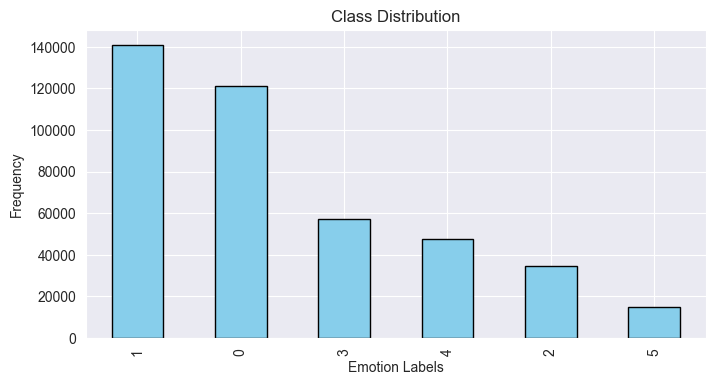


--- Text Analysis ---
Empty or Blank Texts: 0
Average Text Length: 19.21 words
Max Text Length: 178 words
Min Text Length: 1 words
Average Punctuation Count per Entry: 0.00
Average Emoji Count per Entry: 0.00
Average Stop Words per Entry: 9.85
Entries with Only Numbers: 0
Average Excessive Repeated Characters per Entry: 0.01

--- Recommendations ---
Remove duplicate rows.
Normalize excessive repeated characters (e.g., 'looooove' → 'love').


In [17]:
emotions_df = load_data('data/emotions.csv')
explore_data(emotions_df, text_column='text')


#### Class Distribution (Imbalance Visualization)

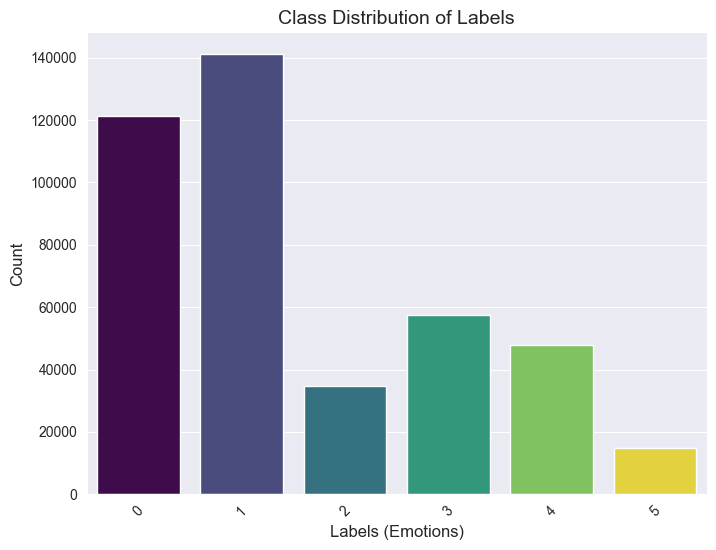

In [19]:
# Plot class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=emotions_df, hue='label', dodge=False, palette='viridis', legend=False)
plt.title("Class Distribution of Labels", fontsize=14)
plt.xlabel("Labels (Emotions)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.show()

#### Remove duplicated data

In [18]:
emotions_df = remove_duplicates(emotions_df, column='text')  # Remove duplicates first
emotions_df = emotions_df[emotions_df['text'].str.strip() != ""].reset_index(drop=True)


### Undersampling data

In [19]:
# Display the first few rows
emotions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393822 entries, 0 to 393821
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         393822 non-null  object
 1   label        393822 non-null  int64 
 2   text_length  393822 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 9.0+ MB


In [20]:
# Undersampling 14k rows from each category 0, 1, 2, 3, 4, 5
# Find the least frequent class count
min_count = emotions_df['label'].value_counts().min()  # Get smallest class size
print(f"Undersampling to {min_count} rows per class")


# Apply undersampling to match the smallest class
undersample_dataset = pd.concat([
    emotions_df[emotions_df['label'] == label].sample(n=min_count, random_state=42)
    for label in emotions_df['label'].unique()
])


# Display new class distribution
print("\nNew Class Distribution After Undersampling:")
print(undersample_dataset['label'].value_counts())


Undersampling to 12407 rows per class

New Class Distribution After Undersampling:
label
4    12407
0    12407
2    12407
1    12407
5    12407
3    12407
Name: count, dtype: int64



--- Basic Information ---
Dataset Shape: (74442, 3)
Columns: ['text', 'label', 'text_length']
Missing Values:
text           0
label          0
text_length    0
dtype: int64
Duplicate Rows: 0

--- Class Distribution ---
label
4    12407
0    12407
2    12407
1    12407
5    12407
3    12407
Name: count, dtype: int64


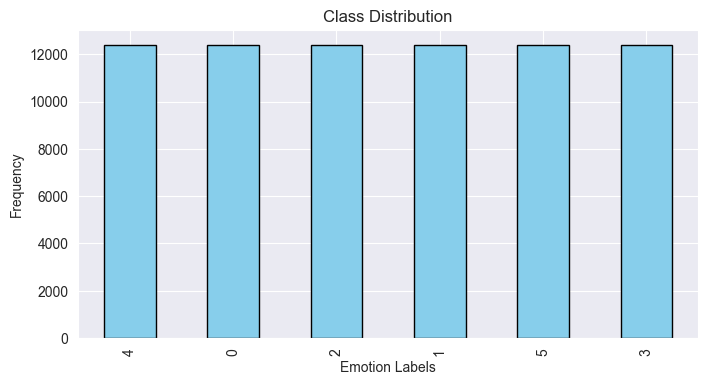


--- Text Analysis ---
Empty or Blank Texts: 0
Average Text Length: 19.50 words
Max Text Length: 101 words
Min Text Length: 1 words
Average Punctuation Count per Entry: 0.00
Average Emoji Count per Entry: 0.00
Average Stop Words per Entry: 10.03
Entries with Only Numbers: 0
Average Excessive Repeated Characters per Entry: 0.01

--- Recommendations ---
Normalize excessive repeated characters (e.g., 'looooove' → 'love').


In [23]:
explore_data(undersample_dataset, text_column='text')  # Adjust 'text' if your column name differs

### Measuring Lemmatization/Stemming Processing Time

In [25]:
# Measure Lemmatization Time
df, lemmatization_time = measure_time(apply_preprocessing, undersample_dataset)
print(f"Lemmatization Time: {lemmatization_time:.4f} seconds")

# Measure Stemming Time
df, stemming_time = measure_time(apply_preprocessing_stemming, undersample_dataset)
print(f"Stemming Time: {stemming_time:.4f} seconds")

Lemmatization Time: 211.4674 seconds
Stemming Time: 242.1169 seconds


## Exploratory Data Analysis (EDA)

#### Class Distribution of Emotion Labels After Undersampling

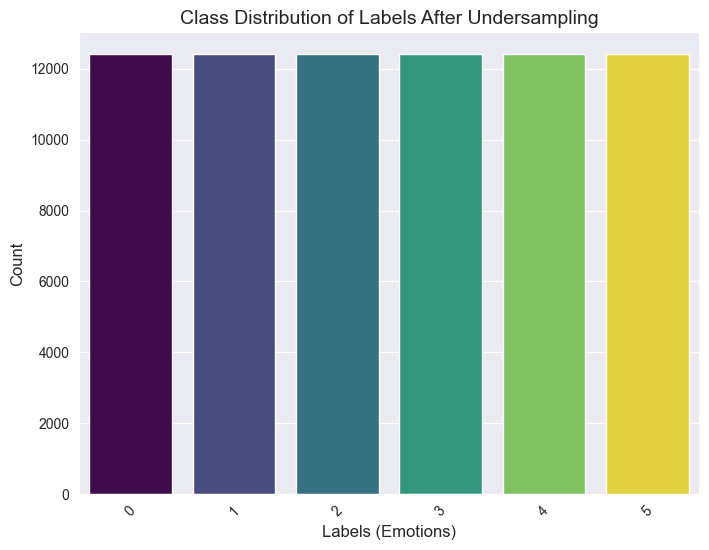

In [24]:
# Plot class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=undersample_dataset, hue='label', dodge=False, palette='viridis', legend=False)
plt.title("Class Distribution of Labels After Undersampling", fontsize=14)
plt.xlabel("Labels (Emotions)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.show()

#### Most Frequent Words in Text Data (Excluding Stopwords)

In [ ]:

stop_words = set(stopwords.words('english'))

# Count word occurrences
word_counts = Counter(" ".join(undersample_dataset['text']).split())
filtered_words = {word: count for word, count in word_counts.items() if word.lower() not in stop_words}

# Plot top 20 words
plt.figure(figsize=(10,5))
plt.barh(list(filtered_words.keys())[:20], list(filtered_words.values())[:20], color='skyblue')
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("Words", fontsize=12)
plt.title("Most Frequent Words in Text Data", fontsize=14)
plt.gca().invert_yaxis()
plt.show()


#### Overall Text Length Distribution

In [ ]:
undersample_dataset['text_length'] = undersample_dataset['text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10,5))
plt.hist(undersample_dataset['text_length'], bins=30, color='skyblue', edgecolor='black')
plt.title("Text Length Distribution", fontsize=14)
plt.xlabel("Number of Words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

#### Word Count Distribution by Emotion

In [ ]:
# !pip install plotly
import plotly.express as px

# Create a column for text length (word count)
undersample_dataset['word_count'] = undersample_dataset['text'].apply(lambda x: len(str(x).split()))

# Box plot for word count distribution across emotion labels
fig = px.box(undersample_dataset, y="word_count", color="label", template="plotly_white")

# Show the plot
fig.show()


#### Class Distribution of Emotion Labels

In [ ]:
# Plot class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=undersample_dataset, hue='label', dodge=False, palette='viridis', legend=False)
plt.title("Class Distribution of Labels", fontsize=14)
plt.xlabel("Labels (Emotions)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.show()

#### Emotion-Specific Keywords

In [ ]:
# TF-IDF analysis
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(undersample_dataset['text'])

# Convert to DataFrame
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df['emotion'] = undersample_dataset['label']

# Find top keywords for each emotion
top_keywords = {}
for emotion in tfidf_df['emotion'].unique():
    emotion_data = tfidf_df[tfidf_df['emotion'] == emotion]
    top_keywords[emotion] = emotion_data.mean(axis=0).sort_values(ascending=False).head(10)

print(top_keywords)


#### Heatmap for TF-IDF Top Keywords

In [ ]:
# Heatmap for TF-IDF scores
tfidf_top_words = tfidf_df.drop('emotion', axis=1).mean(axis=0).sort_values(ascending=False).head(30)
plt.figure(figsize=(12, 8))
sns.heatmap(pd.DataFrame(tfidf_top_words).T, annot=True, cmap='viridis')
plt.title("TF-IDF Top Keywords Heatmap")
plt.show()


In [21]:
emotions_df = apply_preprocessing(undersample_dataset)

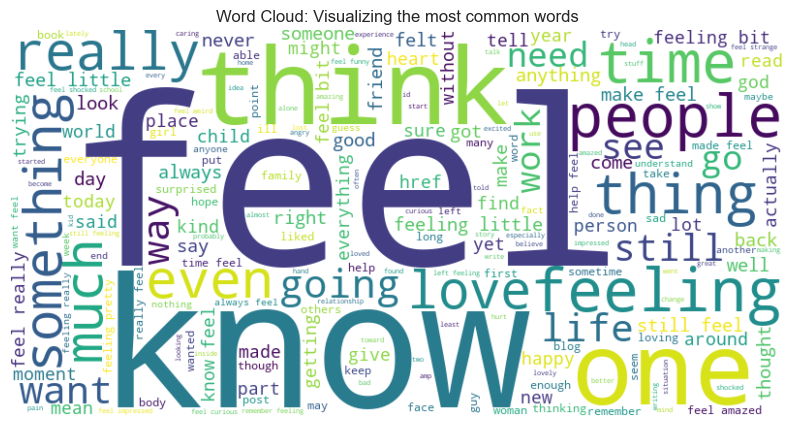

In [28]:
emotions_string = ' '.join(emotions_df['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(emotions_string)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud: Visualizing the most common words")

plt.show()

In [22]:
#create_features_Tfidf
XTfidf, vectorizer = create_features_Tfidf(emotions_df['text'])
XWord2Vec, vectorizer = create_features_Word2Vec(emotions_df['text'])
XCountVectorizer, vectorizer = create_features_CountVectorizer(emotions_df['text'])
# XFastText, vectorizer = create_features_FastText(emotions_df['text'])



y = emotions_df['label']  # Assuming the label column is named 'label'


In [ ]:
# XBERT, vectorizer = create_features_BERT(emotions_df['text'])  # 'text' is the name of your text column
# Run BERT embedding extraction

XBERT = batch_bert_embeddings(emotions_df['text'], batch_size=256)  # Lower batch_size if memory issues occur



In [23]:
# Extract and display the shape of each feature representation
print(f"TF-IDF Shape: {XTfidf.shape}")
print(f"Word2Vec Shape: {XWord2Vec.shape}")
# print(f"FastText Shape: {XFastText.shape}")
# print(f"BERT Embeddings Shape: {XBERT.shape}")


TF-IDF Shape: (74442, 5000)
Word2Vec Shape: (74442, 100)


In [38]:
logistic_model = train_logistic_regression(XTfidf, y)


--- Logistic Regression Evaluation ---
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      2446
           1       0.93      0.92      0.92      2494
           2       0.94      0.96      0.95      2522
           3       0.94      0.94      0.94      2453
           4       0.93      0.90      0.91      2455
           5       0.93      0.97      0.95      2519

    accuracy                           0.93     14889
   macro avg       0.93      0.93      0.93     14889
weighted avg       0.93      0.93      0.93     14889



In [36]:
logistic_model = train_logistic_regression(XWord2Vec, y)

KeyboardInterrupt: 

In [37]:
logistic_model = train_logistic_regression(XCountVectorizer, y)

KeyboardInterrupt: 

In [39]:
random_forest_model = train_random_forest(XTfidf, y) #XTfidf XWord2Vec XCountVectorizer


--- Random Forest Evaluation ---
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      2446
           1       0.97      0.89      0.93      2494
           2       0.92      0.98      0.95      2522
           3       0.93      0.94      0.93      2453
           4       0.92      0.91      0.92      2455
           5       0.92      0.99      0.95      2519

    accuracy                           0.93     14889
   macro avg       0.94      0.93      0.93     14889
weighted avg       0.94      0.93      0.93     14889



In [40]:
svm_model = train_svm(XTfidf, y) #XWord2Vec XCountVectorizer


--- SVM Evaluation ---
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      2446
           1       0.93      0.92      0.92      2494
           2       0.94      0.96      0.95      2522
           3       0.94      0.94      0.94      2453
           4       0.93      0.90      0.91      2455
           5       0.93      0.97      0.95      2519

    accuracy                           0.94     14889
   macro avg       0.94      0.94      0.93     14889
weighted avg       0.94      0.94      0.94     14889



In [85]:
svm_model = train_svm(XCountVectorizer, y)


--- SVM Evaluation ---
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      2446
           1       0.92      0.91      0.92      2494
           2       0.94      0.95      0.94      2522
           3       0.94      0.93      0.93      2453
           4       0.92      0.90      0.91      2455
           5       0.93      0.97      0.95      2519

    accuracy                           0.93     14889
   macro avg       0.93      0.93      0.93     14889
weighted avg       0.93      0.93      0.93     14889



In [24]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(XWord2Vec, y, test_size=0.2, random_state=42)


In [25]:
# Reshape the data for LSTM: (samples, timesteps, features)
X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])


In [ ]:
print(np.mean(X_word2vec, axis=0))
print("---------------------------- ----------------------------")
print(np.std(X_word2vec, axis=0))

In [87]:
# from tensorflow.keras.layers import Bidirectional


# Define the LSTM model
n_classes = len(np.unique(y))

lstm_model = Sequential()
# lstm_model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Correct input shape
lstm_model.add(Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))  # Correct input shape

lstm_model.add(LSTM(256, activation='tanh', return_sequences=True))

lstm_model.add(LSTM(128, activation='tanh', return_sequences=True))  # First LSTM
lstm_model.add(Dropout(0.2))  # Reduced dropout for better learning

lstm_model.add(LSTM(64, activation='tanh'))  # Second LSTM
lstm_model.add(Dropout(0.2))  # Reduced dropout


lstm_model.add(Dense(50, activation='relu'))
lstm_model.add(Dense(n_classes, activation='softmax')) # Output layer for multi-class classification


lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 256)         │       365,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         3,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 615,652 (2.35 MB)

 Trainable params: 615,652 (2.35 MB)

 Non-trainable params: 0 (0.00 B)

In [88]:
# Train the model
lstm_model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, verbose=1)


Epoch 1/20
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 47s 21ms/step - accuracy: 0.3597 - loss: 1.4998
Epoch 2/20
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 36s 20ms/step - accuracy: 0.4365 - loss: 1.3597
Epoch 3/20
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.4499 - loss: 1.3195
Epoch 4/20
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.4649 - loss: 1.2911
Epoch 5/20
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.4717 - loss: 1.2771
Epoch 6/20
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 49s 20ms/step - accuracy: 0.4781 - loss: 1.2687
Epoch 7/20
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 35s 19ms/step - accuracy: 0.4857 - loss: 1.2505
Epoch 8/20
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 44s 20ms/step - accuracy: 0.4950 - loss: 1.2290
Epoch 9/20
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 35s 19ms/step - accuracy: 0.4901 - loss: 1.2346
Epoch 10/20
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 31s 17ms/step - accuracy: 0.4950 - loss: 1.2331
Epoch 11/20
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.5093 - loss: 1.2023
Epoch 12

In [92]:
# Evaluate the model
loss, accuracy = lstm_model.evaluate(X_test_reshaped, y_test, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

466/466 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5432 - loss: 1.1336
Test Loss: 1.1341508626937866
Test Accuracy: 0.5412721037864685


In [31]:
# Define model names and corresponding performance metrics
models = ["Logistic Regression", "Random Forest", "SVM"]
accuracy = [0.93, 0.93, 0.94]
f1_scores = [0.93, 0.93, 0.94]

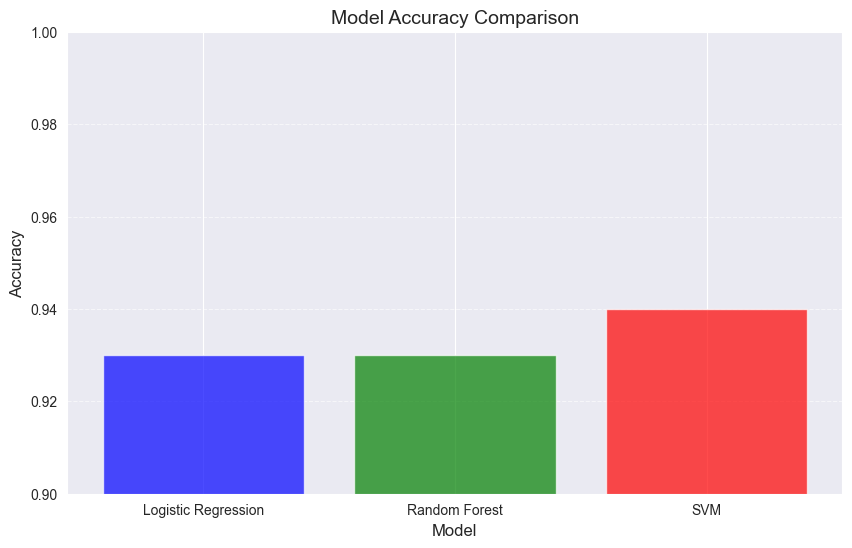

In [32]:
# Plot Model Accuracy Comparison
plt.figure(figsize=(10, 6))
plt.bar(models, accuracy, color=['blue', 'green', 'red'], alpha=0.7)
plt.ylim(0.9, 1.0)  # Set y-axis limit for better visualization
plt.title("Model Accuracy Comparison", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

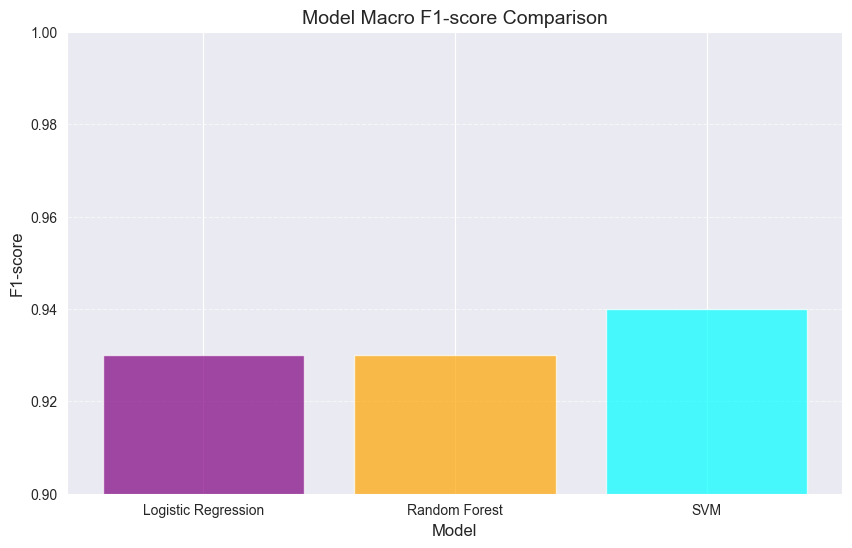

In [97]:
# Plot Model Macro F1-score Comparison
plt.figure(figsize=(10, 6))
plt.bar(models, f1_scores, color=['purple', 'orange', 'cyan'], alpha=0.7)
plt.ylim(0.9, 1.0)  # Set y-axis limit
plt.title("Model Macro F1-score Comparison", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("F1-score", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

## Trying BERT

In [ ]:
XBERT, vectorizer = create_features_BERT(emotions_df['text'])  # 'text' is the name of your text column

Epoch 1/10
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 43s 23ms/step - accuracy: 0.5416 - loss: 1.1282 - val_accuracy: 0.4920 - val_loss: 1.2448
Epoch 2/10
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.5380 - loss: 1.1436 - val_accuracy: 0.5358 - val_loss: 1.1410
Epoch 3/10
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 53s 28ms/step - accuracy: 0.5486 - loss: 1.1084 - val_accuracy: 0.5421 - val_loss: 1.1340
Epoch 4/10
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 44s 23ms/step - accuracy: 0.5544 - loss: 1.1004 - val_accuracy: 0.5376 - val_loss: 1.1367
Epoch 5/10
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - accuracy: 0.5538 - loss: 1.1003 - val_accuracy: 0.5186 - val_loss: 1.1937
Epoch 6/10
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 33s 18ms/step - accuracy: 0.5608 - loss: 1.0896 - val_accuracy: 0.4875 - val_loss: 1.2809
Epoch 7/10
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - accuracy: 0.5513 - loss: 1.1092 - val_accuracy: 0.5435 - val_loss: 1.1310
Epoch 8/10
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.5562 -

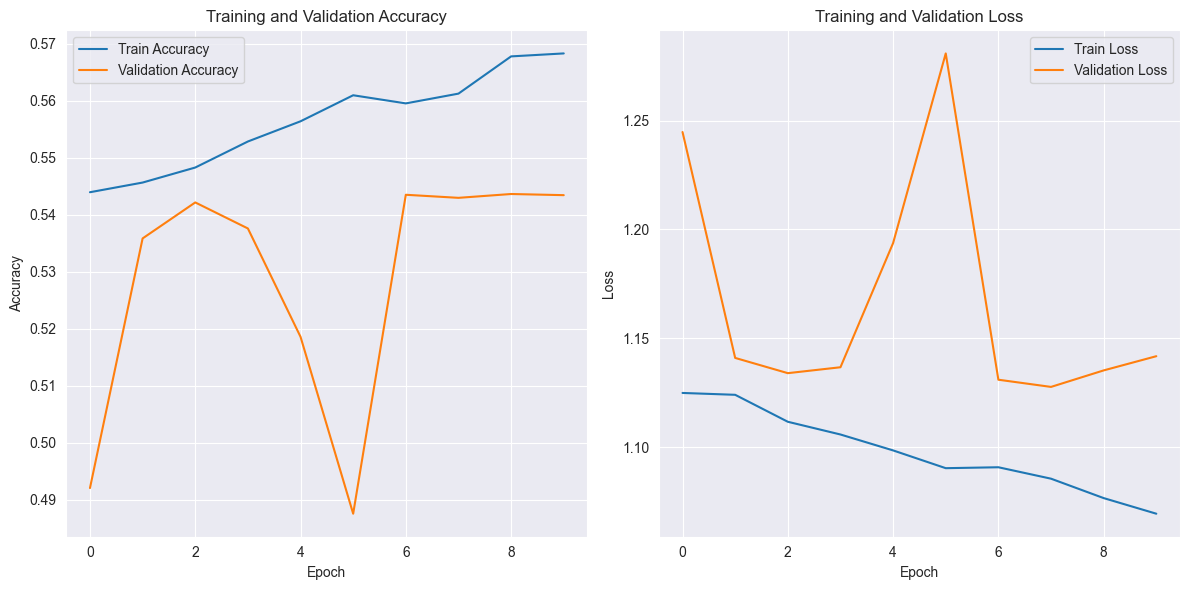

In [56]:
# Early stopping callback: Stop training if the validation loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Train the model with validation data and early stopping
history = lstm_model.fit(X_train_reshaped, y_train,
                         epochs=10, batch_size=32,
                         validation_data=(X_test_reshaped, y_test),
                         callbacks=[early_stopping], verbose=1)

# Plot training and validation loss/accuracy
plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#RNN Model

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input


In [27]:
# Define the SimpleRNN model
n_classes = len(np.unique(y))

rnn_model = Sequential()
rnn_model.add(Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))  # Correct input shape

rnn_model.add(SimpleRNN(256, activation='tanh', return_sequences=True))  # First RNN layer
rnn_model.add(Dropout(0.2))  # Reduce overfitting

rnn_model.add(SimpleRNN(128, activation='tanh', return_sequences=True))  # Second RNN layer
rnn_model.add(Dropout(0.2))

rnn_model.add(SimpleRNN(64, activation='tanh'))  # Final RNN layer
rnn_model.add(Dropout(0.2))

rnn_model.add(Dense(50, activation='relu'))  # Dense hidden layer
rnn_model.add(Dense(n_classes, activation='softmax'))  # Output layer for multi-class classification

# Compile the model
rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
rnn_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 1, 256)         │        91,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 1, 128)         │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         3,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,580 (611.64 KB)

 Trainable params: 156,580 (611.64 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = rnn_model.fit(X_train_reshaped, y_train,
                         epochs=10, batch_size=32,
                         validation_data=(X_test_reshaped, y_test),
                         callbacks=[early_stopping], verbose=1)

# Evaluate the model
loss, accuracy = rnn_model.evaluate(X_test_reshaped, y_test, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Epoch 1/10
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - accuracy: 0.3592 - loss: 1.5045 - val_accuracy: 0.4014 - val_loss: 1.4156
Epoch 2/10
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.4250 - loss: 1.3777 - val_accuracy: 0.4411 - val_loss: 1.3385
Epoch 3/10
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.4373 - loss: 1.3536 - val_accuracy: 0.4431 - val_loss: 1.3317
Epoch 4/10
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.4433 - loss: 1.3433 - val_accuracy: 0.4567 - val_loss: 1.3190
Epoch 5/10
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.4517 - loss: 1.3277 - val_accuracy: 0.4440 - val_loss: 1.3300
Epoch 6/10
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.4538 - loss: 1.3182 - val_accuracy: 0.4541 - val_loss: 1.3025
Epoch 7/10
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.4559 - loss: 1.3142 - val_accuracy: 0.4680 - val_loss: 1.2918
Epoch 8/10
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.4626 - loss: 

In [32]:
# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

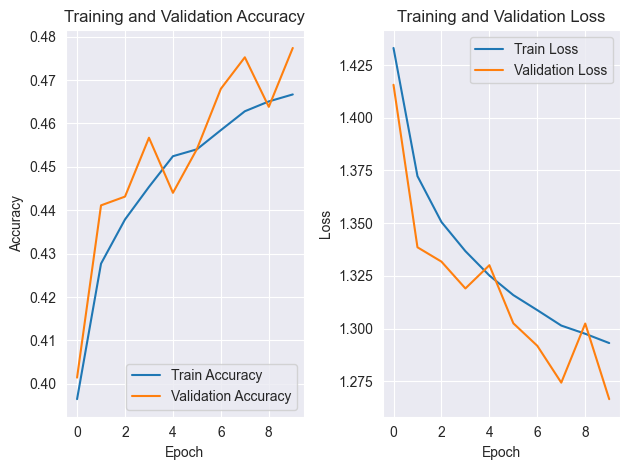

In [34]:
# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()